In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import sklearn.preprocessing
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("hcc_dataset.csv")

**DATA PREPROCESSING**

Analisar a percentagem de missing values, representado por "?", de cada atributo.

In [ ]:
missing_counts = (df == "?").sum()
missing_percentage = (missing_counts / len(df)) * 100
print(missing_percentage)


plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar')
plt.title('Missing values percentage by attribute')
plt.xlabel('Attributes')
plt.ylabel('Percentage of missing values')

plt.axhline(y=25, color='r', linestyle='--', linewidth=1)
plt.axhline(y=50, color='g', linestyle='--', linewidth=1)
plt.axhline(y=75, color='b', linestyle='--', linewidth=1)

plt.show()

Não eliminamos variáveis pois nenhum atributo excede 50% de valores em falta.

Substituir valores "None" nas variáveis 'Encephalopathy' e 'Ascites' por "No" para não serem substituidos por NaN

In [ ]:
df['Encephalopathy'].fillna("No", inplace=True)
df['Ascites'].fillna("No", inplace=True)

Substituir todos os valores em falta ("?") por NaN

In [ ]:
df.replace("?", np.nan, inplace=True)


Completar os atributos numéricos usando a mediana

In [ ]:
# Lista das colunas numéricas que precisam ser tratadas
cols_to_process = ['Age', 'Grams_day', 'Packs_year', 'INR', 'AFP', 'Hemoglobin', 
                   'MCV', 'Leucocytes', 'Platelets', ' Albumin', 'Total_Bil', 
                   'ALT', 'AST', 'GGT', 'ALP', 'TP', 'Creatinine', 'Nodules', 
                   'Major_Dim', 'Dir_Bil', 'Iron', 'Sat', 'Ferritin']

# Converter para tipo numérico e substituir valores NaN pela mediana
for col in cols_to_process:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)



Substituir variáveis binárias por 1 e 0.                                                                                                                       
Nas variáveis avaliadas por estado da doença (Grade I/II, Grade III/IV e Mild, Moderate/Severe) substituir por 1 ou 2, sendo 2 o estado mais avançado(pior).                                                                                                            
Na variável PS, onde é avaliado o estado da pessoa, avaliamos por ordem sendo 0 onde a pessoa está melhor(active) e 4 onde está pior(Disabled)

In [ ]:
df.replace({"Yes": 1, "No": 0, "Female": 1, "Male": 0, "Lives": 1, "Dies": 0, "Grade I/II": 1, "Grade III/IV": 2, "Mild":1, "Moderate/Severe":2, "Active":0, "Selfcare":3, "Restricted":1, "Ambulatory": 2, "Disabled": 4}, inplace=True)

Preencher os valores ausentes com os valores mais frequentes em cada coluna

In [ ]:
df = df.fillna(df.mode().iloc[0])

**Métodos de avaliação da qualidade das variáveis**

1. Feature Importance com Árvores de Decisão ou Random Forests: 
Os modelos baseados em árvores, como Árvores de Decisão e Random Forests, têm métodos embutidos para avaliar a importância das variáveis.
Os valores de importância das características retornados pelo RandomForestClassifier são números entre 0 e 1, e a soma de todas as importâncias é igual a 1. Aqui está um exemplo de como você pode interpretar esses valores:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# Definir X (variáveis independentes) e y (variável dependente/target)
X = df.drop(columns=['Class'])  # Assumindo que 'Classe' é a coluna de target
y = df['Class']

# Identificar colunas categóricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Aplicar One-Hot Encoding
X = pd.get_dummies(X, columns=categorical_cols)

# Dividir o dataset em conjunto de treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinar um modelo de Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Obter importâncias das características
importances = rf.feature_importances_
feature_names = X.columns

# Criar um DataFrame para visualizar as importâncias
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

#Visualização
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})


feature_importances = feature_importances.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 10))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Features Importance')
plt.xticks(rotation=90)  # Rotacionar os rótulos no eixo x para melhor legibilidade
plt.show()



2. Seleção de Características com Recursive Feature Elimination (RFE)
O RFE é uma técnica de seleção de características que ajusta o modelo várias vezes, removendo as características menos importantes a cada vez.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Treinar um modelo de regressão logística
model = LogisticRegression(max_iter=1000)

# Aplicar RFE
rfe = RFE(estimator=model, n_features_to_select=1)
rfe.fit(X_train, y_train)

# Obter ranking das características
ranking = rfe.ranking_
feature_ranking = pd.DataFrame({'Feature': X.columns, 'Ranking': ranking})
feature_ranking = feature_ranking.sort_values(by='Ranking')

print(feature_ranking)


3. Seleção de Características com SelectKBest:
O SelectKBest pode ser usado com uma função de pontuação para selecionar as melhores características. Para classificação, uma função comum é o chi2.

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

# Aplicar SelectKBest
kbest = SelectKBest(score_func=chi2, k='all')
kbest.fit(X_train, y_train)

# Obter pontuações das características
scores = kbest.scores_
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

print(feature_scores)

#Visualização
from sklearn.feature_selection import SelectKBest, chi2

kbest = SelectKBest(score_func=chi2, k='all')
kbest.fit(X_train, y_train)

# Obter pontuações das características
scores = kbest.scores_
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})

# Ordenar o DataFrame por pontuação em ordem decrescente
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

# Criar a tabela
plt.figure(figsize=(10, 10))
plt.bar(feature_scores['Feature'], feature_scores['Score'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Score')
plt.title('Feature Scores')
plt.xticks(rotation=90) 
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Resultados das técnicasambulatorio
feature_importance_rf = pd.DataFrame({
    'Feature' :['ALP', 'AFP', 'Hemoglobin', 'Iron', 'GGT', 'Platelets', 'INR', 'AST', 'MCV', 'Major_Dim', 'Leucocytes', 'Albumin', 'Dir_Bil', 'Age', 'Total_Bil', 'Creatinine', 'ALT', 'Ferritin', 'PS', 'Sat', 'TP', 'Grams_day', 'Packs_year', 'PVT', 'Ascites', 'Metastasis', 'Symptoms', 'Nodules', 'Encephalopathy', 'HBsAg', 'Diabetes', 'Endemic', 'Smoking', 'Varices', 'CRI', 'Alcohol', 'Spleno', 'AHT', 'HCVAb', 'HBcAb', 'Hallmark', 'PHT', 'Cirrhosis', 'Gender', 'Obesity', 'NASH', 'Hemochro', 'HIV', 'HBeAg'],
    'Importance': [0.084795, 0.072460, 0.070927, 0.066636, 0.040003, 0.039688, 0.037464, 0.037307, 0.037105, 0.035314, 0.033237, 0.032853, 0.031938, 0.030341, 0.029758, 0.029640, 0.028214, 0.027715, 0.026128, 0.025600, 0.022502, 0.016429, 0.016191, 0.015120, 0.014709, 0.009974, 0.009289, 0.008589, 0.008507, 0.007267, 0.006778, 0.004740, 0.004491, 0.004233, 0.004121, 0.004017, 0.003985, 0.003951, 0.003383, 0.003105, 0.002659, 0.002533, 0.001901, 0.001676, 0.001132, 0.001071, 0.000524, 0.000000, 0.000000]
})

rfe_ranking = pd.DataFrame({
'Feature' : ['PVT', 'Symptoms', 'Diabetes', 'AHT', 'Ascites', 'CRI', 'PHT', 'Gender', 'Creatinine', 'HIV', 'Hemoglobin', 'Albumin', 'Varices', 'Smoking', 'Cirrhosis', 'Hallmark', 'Obesity', 'Alcohol', 'NASH', 'Major_Dim', 'Encephalopathy', 'PS', 'HCVAb', 'Spleno', 'HBsAg', 'Total_Bil', 'Nodules','Hemochro','Sat', 'Iron', 'TP', 'INR', 'MCV', 'HBcAb', 'ALT', 'AST', 'Metastasis', 'Packs_year', 'Endemic', 'ALP', 'Dir_Bil', 'Grams_day', 'Age', 'GGT', 'Ferritin', 'Leucocytes', 'Platelets', 'AFP', 'HBeAg'],
'Ranking' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
})

select_kbest_scores = pd.DataFrame({
'Feature':['Platelets', 'AFP', 'Leucocytes', 'ALP', 'Ferritin', 'GGT', 'AST', 'Packs_year', 'Iron', 'Total_Bil', 'Dir_Bil', 'Major_Dim', 'Sat', 'PS', 'Ascites', 'ALT', 'PVT', 'Hemoglobin', 'TP', 'Metastasis', 'Encephalopathy' , 'Diabetes', 'CRI','Symptoms', 'Nodules', 'HBcAb', 'Gender', 'Grams_day', 'MCV', 'Albumin', 'AHT', 'Creatinine', 'INR', 'Age', 'Endemic', 'Obesity', 'Alcohol','Hemochro','Varices','Spleno','Cirrhosis' , 'HBsAg', 'Smoking', 'NASH', 'HCVAb', 'HIV', 'PHT', 'Hallmark', 'HBeAg'],
'Score': [453453.232501, 22555.864043, 3568.077384, 1699.420612, 913.960361, 595.140211, 245.121547, 226.884533, 217.601553, 51.117084, 50.326209, 25.571515, 15.616040,12.280817,10.001267,8.014371, 7.594392, 5.000520,4.928658,4.511866, 3.265247, 2.902118, 2.584047, 2.427078, 2.018691, 1.792201, 1.765274, 1.621724, 1.419413, 1.124771, 0.942785, 0.686839, 0.663082, 0.437878, 0.395682, 0.305961, 0.277326, 0.041200, 0.040376, 0.036687, 0.035609, 0.028126, 0.022453, 0.014063, 0.007581, 0.007031, 0.005829, 0.002045, 0.000000]
})

all_features = sorted(set(feature_importance_rf['Feature']).union(rfe_ranking['Feature']).union(select_kbest_scores['Feature']))

# Criar dicionários para mapeamento
feature_importance_dict = dict(zip(feature_importance_rf['Feature'], feature_importance_rf['Importance']))
rfe_ranking_dict = dict(zip(rfe_ranking['Feature'], rfe_ranking['Ranking']))
select_kbest_scores_dict = dict(zip(select_kbest_scores['Feature'], select_kbest_scores['Score']))

# Preencher valores ausentes com NaN
feature_importance_filled = [feature_importance_dict.get(feature, np.nan) for feature in all_features]
rfe_ranking_filled = [rfe_ranking_dict.get(feature, np.nan) for feature in all_features]
select_kbest_scores_filled = [select_kbest_scores_dict.get(feature, np.nan) for feature in all_features]

# Criar DataFrame combinado
combined_df = pd.DataFrame({
    'Feature': all_features,
    'Feature Importance': feature_importance_filled,
    'RFE Ranking': rfe_ranking_filled,
    'Select KBest Score': select_kbest_scores_filled
})

# Normalizar as colunas (assumindo que quanto menor o ranking melhor e quanto maior a pontuação melhor)
combined_df['Normalized Feature Importance'] = combined_df['Feature Importance'] / combined_df['Feature Importance'].max()
combined_df['Normalized RFE Ranking'] = 1 - (combined_df['RFE Ranking'] / combined_df['RFE Ranking'].max())
combined_df['Normalized Select KBest Score'] = combined_df['Select KBest Score'] / combined_df['Select KBest Score'].max()

# Somar as colunas normalizadas para obter um ranking combinado
combined_df['Combined Score'] = (combined_df['Normalized Feature Importance'] + combined_df['Normalized RFE Ranking'] + combined_df['Normalized Select KBest Score']) / 3

# Ordenar pelo ranking combinado
combined_df_sorted = combined_df.sort_values(by='Combined Score', ascending=False)

print(combined_df_sorted)


**Estes foram os resultados obtidos, por ordem decrescente de pontuação. Quanto mais para baixo, menos valiosa é a variável.**


| No |   Feature     | Combined Score |
|----|---------------|----------------|
| 27 | Hemoglobin    |    0.537325    |
| 41 | Platelets     |    0.502954    |
|  2 | ALP           |    0.395807    |
| 29 | Iron          |    0.391361    |
| 11 | Creatinine    |    0.388626    |
| 39 | PVT           |    0.385974    |
|  6 | Albumin       |    0.380848    |
|  8 | Ascites       |    0.357149    |
| 45 | Symptoms      |    0.356245    |
| 12 | Diabetes      |    0.339572    |
| 32 | Major_Dim     |    0.336119    |
|  1 | AHT           |    0.321655    |
|  9 | CRI           |    0.308719    |
|  0 | AFP           |    0.308227    |
| 37 | PHT           |    0.295672    |
| 38 | PS            |    0.286393    |
| 18 | Gender        |    0.285501    |
| 47 | Total_Bil     |    0.273480    |
| 24 | HIV           |    0.265306    |
| 28 | INR           |    0.262920    |
| 48 | Varices       |    0.261538    |
| 43 | Smoking       |    0.255750    |
| 31 | MCV           |    0.254706    |
| 10 | Cirrhosis     |    0.238765    |
| 42 | Sat           |    0.236701    |
|  4 | AST           |    0.235271    |
| 25 | Hallmark      |    0.234942    |
|  7 | Alcohol       |    0.226676    |
| 14 | Encephalopathy|    0.223920    |
| 36 | Obesity       |    0.222137    |
| 46 | TP            |    0.210909    |
| 34 | NASH          |    0.208292    |
|  3 | ALT           |    0.206155    |
| 22 | HBsAg         |    0.191832    |
| 17 | GGT           |    0.191705    |
| 23 | HCVAb         |    0.190169    |
| 44 | Spleno        |    0.185733    |
| 35 | Nodules       |    0.183425    |
| 13 | Dir_Bil       |    0.180009    |
|  5 | Age           |    0.160089    |
| 30 | Leucocytes    |    0.153687    |
| 26 | Hemochro      |    0.144917    |
| 40 | Packs_year    |    0.138644    |
| 16 | Ferritin      |    0.136832    |
| 33 | Metastasis    |    0.120844    |
| 20 | HBcAb         |    0.114248    |
| 19 | Grams_day     |    0.112203    |
| 15 | Endemic       |    0.086661    |
| 21 | HBeAg         |    0.000000    |


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap das pontuações normalizadas
plt.figure(figsize=(12, 8))
sns.heatmap(combined_df_sorted[['Normalized Feature Importance', 'Normalized RFE Ranking', 'Normalized Select KBest Score']].T, annot=True, cmap='coolwarm')
plt.show()


Gráficos de cada atributo em relação a quem vive e morre para podermos analisar se retiramos mais alguma variável

In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='Age', by='Class', grid=False)
plt.title('Boxplot of Age by Class')
plt.xlabel('Class')
plt.ylabel('Age')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()

In [ ]:

male_die = df[(df['Gender'] == 0) & (df['Class'] == 0)]['Gender'].count()
male_live = df[(df['Gender'] == 0) & (df['Class'] == 1)]['Gender'].count()
female_die = df[(df['Gender'] == 1) & (df['Class'] == 0)]['Gender'].count()
female_live = df[(df['Gender'] == 1) & (df['Class'] == 1)]['Gender'].count()

plt.figure(figsize=(8, 6))
bars1 = plt.bar(['Male'], [male_live], color='blue', label='Male (Lives)')
bars2 = plt.bar(['Male'], [male_die], bottom=[male_live], color='lightblue', label='Male (Dies)')
bars3 = plt.bar(['Female'], [female_live], color='red', label='Female (Lives)')
bars4 = plt.bar(['Female'], [female_die], bottom=[female_live], color='lightcoral', label='Female (Dies)')


plt.title('Distribution of Gender and Survival')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=0)
plt.show()


In [ ]:

symptoms_die = df[(df['Symptoms'] == 1) & (df['Class'] == 0)]['Symptoms'].count()
no_symptoms_die = df[(df['Symptoms'] == 0) & (df['Class'] == 0)]['Symptoms'].count()
symptoms_live = df[(df['Symptoms'] == 1) & (df['Class'] == 1)]['Symptoms'].count()
no_symptoms_live = df[(df['Symptoms'] == 0) & (df['Class'] == 1)]['Symptoms'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [symptoms_die, no_symptoms_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [symptoms_live, no_symptoms_live], width=0.4, color=['red'], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of Symptoms in Deceased vs. Lived Patients')
plt.xlabel('Symptoms')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['With Symptoms', 'No Symptoms'])
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:


# Count the occurrences of males and females who live or die
no_alcohol_die = df[(df['Alcohol'] == 0) & (df['Class'] == 0)]['Alcohol'].count()
no_alcohol_live = df[(df['Alcohol'] == 0) & (df['Class'] == 1)]['Alcohol'].count()
alcohol_die = df[(df['Alcohol'] == 1) & (df['Class'] == 0)]['Alcohol'].count()
alcohol_live = df[(df['Alcohol'] == 1) & (df['Class'] == 1)]['Alcohol'].count()

# Plotting a stacked bar chart
plt.figure(figsize=(8, 6))
bars1 = plt.bar(['No Alcohol (Lives)'], [no_alcohol_live], color='lightblue')
bars2 = plt.bar(['No Alcohol (Dies)'], [no_alcohol_die], color='blue')
bars3 = plt.bar(['Alcohol (Lives)'], [alcohol_live], color='lightcoral')
bars4 = plt.bar(['Alcohol (Dies)'], [alcohol_die], color='red')
    
plt.title('Distribution of Alcohol Consumption and Survival')
plt.xlabel('Alcohol')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:


# Count the occurrences of people who die and live with and without HBsAg
hbsag_die = df[(df['HBsAg'] == 1) & (df['Class'] == 0)]['HBsAg'].count()
no_hbsag_die = df[(df['HBsAg'] == 0) & (df['Class'] == 0)]['HBsAg'].count()
hbsag_live = df[(df['HBsAg'] == 1) & (df['Class'] == 1)]['HBsAg'].count()
no_hbsag_live = df[(df['HBsAg'] == 0) & (df['Class'] == 1)]['HBsAg'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [hbsag_die, no_hbsag_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [hbsag_live, no_hbsag_live], width=0.4, color=['red'], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of HBsAg in Deceased vs. Lived Patients')
plt.xlabel('HBsAg')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['Positive', 'Negative'])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


# Count the occurrences of people who die and live with and without HBeAg
hbeag_die = df[(df['HBeAg'] == 1) & (df['Class'] == 0)]['HBeAg'].count()
no_hbeag_die = df[(df['HBeAg'] == 0) & (df['Class'] == 0)]['HBeAg'].count()
hbeag_live = df[(df['HBeAg'] == 1) & (df['Class'] == 1)]['HBeAg'].count()
no_hbeag_live = df[(df['HBeAg'] == 0) & (df['Class'] == 1)]['HBeAg'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [hbeag_die, no_hbeag_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [hbeag_live, no_hbeag_live], width=0.4, color=['red'], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of HBeAg in Deceased vs. Lived Patients')
plt.xlabel('HBeAg')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['Positive', 'Negative'])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


# Count the occurrences of people who die and live with and without HBcAb
hbcab_die = df[(df['HBcAb'] == 1) & (df['Class'] == 0)]['HBcAb'].count()
no_hbcab_die = df[(df['HBcAb'] == 0) & (df['Class'] == 0)]['HBcAb'].count()
hbcab_live = df[(df['HBcAb'] == 1) & (df['Class'] == 1)]['HBcAb'].count()
no_hbcab_live = df[(df['HBcAb'] == 0) & (df['Class'] == 1)]['HBcAb'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [hbcab_die, no_hbcab_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [hbcab_live, no_hbcab_live], width=0.4, color=['red'], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of HBcAb in Deceased vs. Lived Patients')
plt.xlabel('HBcAb')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['Positive', 'Negative'])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


# Count the occurrences of people who die and live with and without HCVAb
hcvab_die = df[(df['HCVAb'] == 1) & (df['Class'] == 0)]['HCVAb'].count()
no_hcvab_die = df[(df['HCVAb'] == 0) & (df['Class'] == 0)]['HCVAb'].count()
hcvab_live = df[(df['HCVAb'] == 1) & (df['Class'] == 1)]['HCVAb'].count()
no_hcvab_live = df[(df['HCVAb'] == 0) & (df['Class'] == 1)]['HCVAb'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [hcvab_die, no_hcvab_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [hcvab_live, no_hcvab_live], width=0.4, color=['red'], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of HCVAb in Deceased vs. Lived Patients')
plt.xlabel('HCVAb')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['Positive', 'Negative'])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


# Count the occurrences of people who die and live with and without Cirrhosis
cirrhosis_die = df[(df['Cirrhosis'] == 1) & (df['Class'] == 0)]['Cirrhosis'].count()
no_cirrhosis_die = df[(df['Cirrhosis'] == 0) & (df['Class'] == 0)]['Cirrhosis'].count()
cirrhosis_live = df[(df['Cirrhosis'] == 1) & (df['Class'] == 1)]['Cirrhosis'].count()
no_cirrhosis_live = df[(df['Cirrhosis'] == 0) & (df['Class'] == 1)]['Cirrhosis'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [cirrhosis_die, no_cirrhosis_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [cirrhosis_live, no_cirrhosis_live], width=0.4, color=['red'], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of Cirrhosis in Deceased vs. Lived Patients')
plt.xlabel('Cirrhosis')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['Present', 'Absent'])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


# Count the occurrences of people who die and live with and without Endemic
endemic_die = df[(df['Endemic'] == 1) & (df['Class'] == 0)]['Endemic'].count()
no_endemic_die = df[(df['Endemic'] == 0) & (df['Class'] == 0)]['Endemic'].count()
endemic_live = df[(df['Endemic'] == 1) & (df['Class'] == 1)]['Endemic'].count()
no_endemic_live = df[(df['Endemic'] == 0) & (df['Class'] == 1)]['Endemic'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [endemic_die, no_endemic_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [endemic_live, no_endemic_live], width=0.4, color=['red'], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of Endemic in Deceased vs. Lived Patients')
plt.xlabel('Endemic')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['Present', 'Absent'])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


# Count the occurrences of people who die and live with and without Smoking
smoking_die = df[(df['Smoking'] == 1) & (df['Class'] == 0)]['Smoking'].count()
no_smoking_die = df[(df['Smoking'] == 0) & (df['Class'] == 0)]['Smoking'].count()
smoking_live = df[(df['Smoking'] == 1) & (df['Class'] == 1)]['Smoking'].count()
no_smoking_live = df[(df['Smoking'] == 0) & (df['Class'] == 1)]['Smoking'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [smoking_die, no_smoking_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [smoking_live, no_smoking_live], width=0.4, color=['red'], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of Smoking in Deceased vs. Lived Patients')
plt.xlabel('Smoking')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['Smoker', 'Non-Smoker'])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


# Count the occurrences of people who die and live with and without Diabetes
diabetes_die = df[(df['Diabetes'] == 1) & (df['Class'] == 0)]['Diabetes'].count()
no_diabetes_die = df[(df['Diabetes'] == 0) & (df['Class'] == 0)]['Diabetes'].count()
diabetes_live = df[(df['Diabetes'] == 1) & (df['Class'] == 1)]['Diabetes'].count()
no_diabetes_live = df[(df['Diabetes'] == 0) & (df['Class'] == 1)]['Diabetes'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [diabetes_die, no_diabetes_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [diabetes_live, no_diabetes_live], width=0.4, color=['red'], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of Diabetes in Deceased vs. Lived Patients')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['Diabetic', 'Non-Diabetic'])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


# Count the occurrences of people who die and live with and without Obesity
obesity_die = df[(df['Obesity'] == 1) & (df['Class'] == 0)]['Obesity'].count()
no_obesity_die = df[(df['Obesity'] == 0) & (df['Class'] == 0)]['Obesity'].count()
obesity_live = df[(df['Obesity'] == 1) & (df['Class'] == 1)]['Obesity'].count()
no_obesity_live = df[(df['Obesity'] == 0) & (df['Class'] == 1)]['Obesity'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [obesity_die, no_obesity_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [obesity_live, no_obesity_live], width=0.4, color=['red'], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of Obesity in Deceased vs. Lived Patients')
plt.xlabel('Obesity')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['Obese', 'Non-Obese'])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


# Count the occurrences of people who die and live with and without Hemochromatosis
hemochro_die = df[(df['Hemochro'] == 1) & (df['Class'] == 0)]['Hemochro'].count()
no_hemochro_die = df[(df['Hemochro'] == 0) & (df['Class'] == 0)]['Hemochro'].count()
hemochro_live = df[(df['Hemochro'] == 1) & (df['Class'] == 1)]['Hemochro'].count()
no_hemochro_live = df[(df['Hemochro'] == 0) & (df['Class'] == 1)]['Hemochro'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [hemochro_die, no_hemochro_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [hemochro_live, no_hemochro_live], width=0.4, color=['red'], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of Hemochromatosis in Deceased vs. Lived Patients')
plt.xlabel('Hemochromatosis')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['Present', 'Absent'])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


# Count the occurrences of people who die and live with and without Arterial Hypertension
aht_die = df[(df['AHT'] == 1) & (df['Class'] == 0)]['AHT'].count()
no_aht_die = df[(df['AHT'] == 0) & (df['Class'] == 0)]['AHT'].count()
aht_live = df[(df['AHT'] == 1) & (df['Class'] == 1)]['AHT'].count()
no_aht_live = df[(df['AHT'] == 0) & (df['Class'] == 1)]['AHT'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [aht_die, no_aht_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [aht_live, no_aht_live], width=0.4, color=['red'], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of Arterial Hypertension in Deceased vs. Lived Patients')
plt.xlabel('Arterial Hypertension')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['Present', 'Absent'])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


# Count the occurrences of people who die and live with and without HIV
hiv_die = df[(df['HIV'] == 1) & (df['Class'] == 0)]['HIV'].count()
no_hiv_die = df[(df['HIV'] == 0) & (df['Class'] == 0)]['HIV'].count()
hiv_live = df[(df['HIV'] == 1) & (df['Class'] == 1)]['HIV'].count()
no_hiv_live = df[(df['HIV'] == 0) & (df['Class'] == 1)]['HIV'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [hiv_die, no_hiv_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [hiv_live, no_hiv_live], width=0.4, color=['red'], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of HIV in Deceased vs. Lived Patients')
plt.xlabel('HIV')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['Present', 'Absent'])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


# Count the occurrences of people who die and live with and without NASH
nash_die = df[(df['NASH'] == 1) & (df['Class'] == 0)]['NASH'].count()
no_nash_die = df[(df['NASH'] == 0) & (df['Class'] == 0)]['NASH'].count()
nash_live = df[(df['NASH'] == 1) & (df['Class'] == 1)]['NASH'].count()
no_nash_live = df[(df['NASH'] == 0) & (df['Class'] == 1)]['NASH'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [nash_die, no_nash_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [nash_live, no_nash_live], width=0.4, color=['red'], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of NASH in Deceased vs. Lived Patients')
plt.xlabel('NASH')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['Present', 'Absent'])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


# Count the occurrences of people who die and live with and without Varices
varices_die = df[(df['Varices'] == 1) & (df['Class'] == 0)]['Varices'].count()
no_varices_die = df[(df['Varices'] == 0) & (df['Class'] == 0)]['Varices'].count()
varices_live = df[(df['Varices'] == 1) & (df['Class'] == 1)]['Varices'].count()
no_varices_live = df[(df['Varices'] == 0) & (df['Class'] == 1)]['Varices'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [varices_die, no_varices_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [varices_live, no_varices_live], width=0.4, color=['red'], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of Varices in Deceased vs. Lived Patients')
plt.xlabel('Varices')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['Present', 'Absent'])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


# Count the occurrences of people who die and live with and without Splenomegaly
spleno_die = df[(df['Spleno'] == 1) & (df['Class'] == 0)]['Spleno'].count()
no_spleno_die = df[(df['Spleno'] == 0) & (df['Class'] == 0)]['Spleno'].count()
spleno_live = df[(df['Spleno'] == 1) & (df['Class'] == 1)]['Spleno'].count()
no_spleno_live = df[(df['Spleno'] == 0) & (df['Class'] == 1)]['Spleno'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [spleno_die, no_spleno_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [spleno_live, no_spleno_live], width=0.4, color=['red'], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of Splenomegaly in Deceased vs. Lived Patients')
plt.xlabel('Splenomegaly')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['Present', 'Absent'])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


# Count the occurrences of people who die and live with and without Portal Hypertension (PHT)
pht_die = df[(df['PHT'] == 1) & (df['Class'] == 0)]['PHT'].count()
no_pht_die = df[(df['PHT'] == 0) & (df['Class'] == 0)]['PHT'].count()
pht_live = df[(df['PHT'] == 1) & (df['Class'] == 1)]['PHT'].count()
no_pht_live = df[(df['PHT'] == 0) & (df['Class'] == 1)]['PHT'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [pht_die, no_pht_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [pht_live, no_pht_live], width=0.4, color=['red'], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of Portal Hypertension (PHT) in Deceased vs. Lived Patients')
plt.xlabel('Portal Hypertension (PHT)')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['Present', 'Absent'])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


# Count the occurrences of people who die and live with and without Portal Vein Thrombosis (PVT)
pvt_die = df[(df['PVT'] == 1) & (df['Class'] == 0)]['PVT'].count()
no_pvt_die = df[(df['PVT'] == 0) & (df['Class'] == 0)]['PVT'].count()
pvt_live = df[(df['PVT'] == 1) & (df['Class'] == 1)]['PVT'].count()
no_pvt_live = df[(df['PVT'] == 0) & (df['Class'] == 1)]['PVT'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [pvt_die, no_pvt_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [pvt_live, no_pvt_live], width=0.4, color=['red'], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of Portal Vein Thrombosis (PVT) in Deceased vs. Lived Patients')
plt.xlabel('Portal Vein Thrombosis (PVT)')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['Present', 'Absent'])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


# Count the occurrences of people who die and live with and without Metastasis
meta_die = df[(df['Metastasis'] == 1) & (df['Class'] == 0)]['Metastasis'].count()
no_meta_die = df[(df['Metastasis'] == 0) & (df['Class'] == 0)]['Metastasis'].count()
meta_live = df[(df['Metastasis'] == 1) & (df['Class'] == 1)]['Metastasis'].count()
no_meta_live = df[(df['Metastasis'] == 0) & (df['Class'] == 1)]['Metastasis'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [meta_die, no_meta_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [meta_live, no_meta_live], width=0.4, color=['red'], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of Metastasis in Deceased vs. Lived Patients')
plt.xlabel('Metastasis')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['Present', 'Absent'])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


# Count the occurrences of people who die and live with and without Hallmark
hallmark_die = df[(df['Hallmark'] == 1) & (df['Class'] == 0)]['Hallmark'].count()
no_hallmark_die = df[(df['Hallmark'] == 0) & (df['Class'] == 0)]['Hallmark'].count()
hallmark_live = df[(df['Hallmark'] == 1) & (df['Class'] == 1)]['Hallmark'].count()
no_hallmark_live = df[(df['Hallmark'] == 0) & (df['Class'] == 1)]['Hallmark'].count()

# Plotting a bar chart
plt.figure(figsize=(10, 6))

# Deceased patients
bars1 = plt.bar([0, 1], [hallmark_die, no_hallmark_die], width=0.4, color=['lightcoral'], label='Deceased')
# Patients who lived
bars2 = plt.bar([0.4, 1.4], [hallmark_live, no_hallmark_live], width=0.4, color=['red',], label='Lived')

# Adding labels on top of each bar
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.title('Distribution of Hallmark in Deceased vs. Lived Patients')
plt.xlabel('Hallmark')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['Present', 'Absent'])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='Grams_day', by='Class', grid=False)
plt.title('Boxplot of Grams_day by Class')
plt.xlabel('Class')
plt.ylabel('Grams_day')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()

In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='Packs_year', by='Class', grid=False)
plt.title('Boxplot of Packs_year by Class')
plt.xlabel('Class')
plt.ylabel('Packs_year')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


In [ ]:

plt.figure(figsize=(10, 6))
df.groupby(['PS', 'Class']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribution of PS by Class')
plt.xlabel('PS')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Class', labels=['Lives', 'Dies'])
plt.tight_layout()
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='INR', by='Class', grid=False)
plt.title('Boxplot of INR by Class')
plt.xlabel('Class')
plt.ylabel('INR')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='AFP', by='Class', grid=False)
plt.title('Boxplot of AFP by Class')
plt.xlabel('Class')
plt.ylabel('AFP')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='Hemoglobin', by='Class', grid=False)
plt.title('Boxplot of Hemoglobin by Class')
plt.xlabel('Class')
plt.ylabel('Hemoglobin')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='MCV', by='Class', grid=False)
plt.title('Boxplot of MCV by Class')
plt.xlabel('Class')
plt.ylabel('MCV')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='Leucocytes', by='Class', grid=False)
plt.title('Boxplot of Leucocytes by Class')
plt.xlabel('Class')
plt.ylabel('Leucocytes')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='Platelets', by='Class', grid=False)
plt.title('Boxplot of Platelets by Class')
plt.xlabel('Class')
plt.ylabel('Platelets')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column=' Albumin', by='Class', grid=False)
plt.title('Boxplot of Albumin by Class')
plt.xlabel('Class')
plt.ylabel('Albumin')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()



In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='Total_Bil', by='Class', grid=False)
plt.title('Boxplot of Total Bilirubin by Class')
plt.xlabel('Class')
plt.ylabel('Total Bilirubin')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='ALT', by='Class', grid=False)
plt.title('Boxplot of ALT by Class')
plt.xlabel('Class')
plt.ylabel('ALT')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='AST', by='Class', grid=False)
plt.title('Boxplot of AST by Class')
plt.xlabel('Class')
plt.ylabel('AST')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='GGT', by='Class', grid=False)
plt.title('Boxplot of GGT by Class')
plt.xlabel('Class')
plt.ylabel('GGT')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='ALP', by='Class', grid=False)
plt.title('Boxplot of ALP by Class')
plt.xlabel('Class')
plt.ylabel('ALP')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='TP', by='Class', grid=False)
plt.title('Boxplot of Total Proteins (TP) by Class')
plt.xlabel('Class')
plt.ylabel('TP')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='Creatinine', by='Class', grid=False)
plt.title('Boxplot of Creatinine by Class')
plt.xlabel('Class')
plt.ylabel('Creatinine')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='Nodules', by='Class', grid=False)
plt.title('Boxplot of Nodules by Class')
plt.xlabel('Class')
plt.ylabel('Nodules')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='Major_Dim', by='Class', grid=False)
plt.title('Boxplot of Major_Dim by Class')
plt.xlabel('Class')
plt.ylabel('Major_Dim')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='Dir_Bil', by='Class', grid=False)
plt.title('Boxplot of Dir_Bil by Class')
plt.xlabel('Class')
plt.ylabel('Dir_Bil')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='Iron', by='Class', grid=False)
plt.title('Boxplot of Iron by Class')
plt.xlabel('Class')
plt.ylabel('Iron')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='Sat', by='Class', grid=False)
plt.title('Boxplot of Saturation (Sat) by Class')
plt.xlabel('Class')
plt.ylabel('Saturation (Sat)')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


In [ ]:

plt.figure(figsize=(8, 6))
df.boxplot(column='Ferritin', by='Class', grid=False)
plt.title('Boxplot of Ferritin by Class')
plt.xlabel('Class')
plt.ylabel('Ferritin')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(labels=['Lives = 1'])
plt.show()


Através do gráficos acima, analisamos cada uma das diferentes variáveis para avaliar a sua importância na determinação da sobrevivência de pacientes com carcinoma hepatocelular.

A qualidade de uma variável é medida de acordo com a sua implicação na sobrevivência dos pacientes que a apresentam.
As seguintes variáveis foram eliminadas:
- Symptoms - Com sintomas a distinção entre pacientes que vivem e morrem é menor que 10%
- Diabetes - Com sintomas a distinção entre pacientes que vivem e morrem é menor que 10%
- HbeAg - Como apenas 1 paciente de 165 apresenta esta variável positiva, esta não é fiavél
- HIV - Como apenas 3 pacientes de 165 apresentam esta variável positiva, esta não é fiavél
- Endemic - Como apenas 10 pacientes de 165 apresentam esta variável positiva, esta não é fiavél
- Hemochro - Como apenas 7 pacientes de 165 apresentam esta variável positiva, esta não é fiavél
- HCVAb - A diferença do número de pacientes que vive/morre, quando esta variável está presente, não é significativa
- NASH - Como apenas 8 pacientes de 165 apresentam esta variável positiva, esta não é fiavél
- Grams_day - Não existe diferença significativa de valores nos pacientes que vivem/morrem
- INR - Não existe diferença significativa de valores nos pacientes que vivem/morrem
- Total_Bil - Não existe diferença significativa de valores nos pacientes que vivem/morrem
- TP - Não existe diferença significativa de valores nos pacientes que vivem/morrem



**Avaliamos a precisão dos modelos antes e depois de retirarmos variáveis**

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc


X = df.drop(columns=['Class'])
y = df['Class']

# Identificar colunas categóricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Aplicar One-Hot Encoding
X = pd.get_dummies(X, columns=categorical_cols)

# Dividir o dataset em conjunto de treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Garantir que os dados são contíguos em memória
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)

# Criar os modelos
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Logistic\n Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient\n Boosting': GradientBoostingClassifier(random_state=42),
}
# Treinar e avaliar os modelos
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob) if y_prob is not None else (None, None, None)
    roc_auc = auc(fpr, tpr) if y_prob is not None else None
    
    # Calculando TNR e FNR
    tn, fp, fn, tp = conf_matrix.ravel()
    tnr = tn / (tn + fp)  # True Negative Rate
    fnr = fn / (fn + tp)  # False Negative Rate
    
    # TNR-FNR curve
    tnr_fnr = (tnr, fnr)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'report': report,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'tnr_fnr': tnr_fnr,
    }

# Comparação de Acurácia
accuracy_data = {name: results[name]['accuracy'] for name in results.keys()}
accuracy_df = pd.DataFrame.from_dict(accuracy_data, orient='index', columns=['Accuracy'])
print(accuracy_df)

# Plotting accuracy
sns.barplot(x=accuracy_df.index, y='Accuracy', data=accuracy_df)
plt.title('Accuracy Comparison')
plt.show()

# Comparação do Relatório de Classificação
classification_reports = {name: pd.DataFrame(results[name]['report']).transpose() for name in results.keys()}

for name, report in classification_reports.items():
    print(f'Classification Report for {name}:\n', report)

# Matriz de Confusão
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

for ax, (name, result) in zip(axes.flatten(), results.items()):
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ROC Curve e AUC
plt.figure(figsize=(10, 8))

for name, result in results.items():
    if result['roc_auc'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

# TNR-FNR Curve
plt.figure(figsize=(10, 8))

for name, result in results.items():
    tnr, fnr = result['tnr_fnr']
    plt.plot(fnr, tnr, 'o', label=f'{name} (TNR = {tnr:.2f}, FNR = {fnr:.2f})')

plt.plot([0, 1], [1, 0], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Negative Rate')
plt.ylabel('True Negative Rate')
plt.title('TNR-FNR Curve Comparison')
plt.legend(loc='lower right')
plt.show()


**Sem as varáveis onde com ou sem esse parâmetro existia menos de 10% das pessoas - 'HBeAg', 'HIV', 'Endemic', 'Hemochro', 'NASH'**

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

X = df.drop(columns=['Class','HBeAg', 'HIV', 'Endemic', 'Hemochro', 'NASH'])
y = df['Class']

# Identificar colunas categóricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Aplicar One-Hot Encoding
X = pd.get_dummies(X, columns=categorical_cols)

# Dividir o dataset em conjunto de treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Garantir que os dados são contíguos em memória
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)

# Criar os modelos
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Logistic\n Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient\n Boosting': GradientBoostingClassifier(random_state=42),
}
# Treinar e avaliar os modelos
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob) if y_prob is not None else (None, None, None)
    roc_auc = auc(fpr, tpr) if y_prob is not None else None
    
    # Calculando TNR e FNR
    tn, fp, fn, tp = conf_matrix.ravel()
    tnr = tn / (tn + fp)  # True Negative Rate
    fnr = fn / (fn + tp)  # False Negative Rate
    
    # TNR-FNR curve
    tnr_fnr = (tnr, fnr)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'report': report,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'tnr_fnr': tnr_fnr,
    }

# Comparação de Acurácia
accuracy_data = {name: results[name]['accuracy'] for name in results.keys()}
accuracy_df = pd.DataFrame.from_dict(accuracy_data, orient='index', columns=['Accuracy'])
print(accuracy_df)

# Plotting accuracy
sns.barplot(x=accuracy_df.index, y='Accuracy', data=accuracy_df)
plt.title('Accuracy Comparison')
plt.show()

# Comparação do Relatório de Classificação
classification_reports = {name: pd.DataFrame(results[name]['report']).transpose() for name in results.keys()}

for name, report in classification_reports.items():
    print(f'Classification Report for {name}:\n', report)

# Matriz de Confusão
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

for ax, (name, result) in zip(axes.flatten(), results.items()):
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ROC Curve e AUC
plt.figure(figsize=(10, 8))

for name, result in results.items():
    if result['roc_auc'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

# TNR-FNR Curve
plt.figure(figsize=(10, 8))

for name, result in results.items():
    tnr, fnr = result['tnr_fnr']
    plt.plot(fnr, tnr, 'o', label=f'{name} (TNR = {tnr:.2f}, FNR = {fnr:.2f})')

plt.plot([0, 1], [1, 0], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Negative Rate')
plt.ylabel('True Negative Rate')
plt.title('TNR-FNR Curve Comparison')
plt.legend(loc='lower right')
plt.show()


In [ ]:
df.columns

**Sem as varáveis eliminadas a partir da leitura dos gráficos - 'Symptoms', 'Diabetes', 'HBeAg', 'HIV', Endemic', Hemochro', HCVAb', 'NASH', 'Grams_day', 'INR', 'Total_Bil', 'TP'**

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc


X = df.drop(columns=['Class','Symptoms', 'Diabetes', 'HBeAg', 'HIV', 'Endemic', 'Hemochro', 'HCVAb', 'NASH', 'Grams_day', 'INR', 'Total_Bil', 'TP'])
y = df['Class']

# Identificar colunas categóricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Aplicar One-Hot Encoding
X = pd.get_dummies(X, columns=categorical_cols)

# Dividir o dataset em conjunto de treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Garantir que os dados são contíguos em memória
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)

# Criar os modelos
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Logistic\n Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient\n Boosting': GradientBoostingClassifier(random_state=42),
}
# Treinar e avaliar os modelos
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob) if y_prob is not None else (None, None, None)
    roc_auc = auc(fpr, tpr) if y_prob is not None else None
    
    # Calculando TNR e FNR
    tn, fp, fn, tp = conf_matrix.ravel()
    tnr = tn / (tn + fp)  # True Negative Rate
    fnr = fn / (fn + tp)  # False Negative Rate
    
    # TNR-FNR curve
    tnr_fnr = (tnr, fnr)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'report': report,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'tnr_fnr': tnr_fnr,
    }

# Comparação de Acurácia
accuracy_data = {name: results[name]['accuracy'] for name in results.keys()}
accuracy_df = pd.DataFrame.from_dict(accuracy_data, orient='index', columns=['Accuracy'])
print(accuracy_df)

# Plotting accuracy
sns.barplot(x=accuracy_df.index, y='Accuracy', data=accuracy_df)
plt.title('Accuracy Comparison')
plt.show()

# Comparação do Relatório de Classificação
classification_reports = {name: pd.DataFrame(results[name]['report']).transpose() for name in results.keys()}

for name, report in classification_reports.items():
    print(f'Classification Report for {name}:\n', report)

# Matriz de Confusão
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

for ax, (name, result) in zip(axes.flatten(), results.items()):
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ROC Curve e AUC
plt.figure(figsize=(10, 8))

for name, result in results.items():
    if result['roc_auc'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

# TNR-FNR Curve
plt.figure(figsize=(10, 8))

for name, result in results.items():
    tnr, fnr = result['tnr_fnr']
    plt.plot(fnr, tnr, 'o', label=f'{name} (TNR = {tnr:.2f}, FNR = {fnr:.2f})')

plt.plot([0, 1], [1, 0], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Negative Rate')
plt.ylabel('True Negative Rate')
plt.title('TNR-FNR Curve Comparison')
plt.legend(loc='lower right')
plt.show()



| No |   Feature     | Combined Score |
|----|---------------|----------------|
| 27 | Hemoglobin    |    0.537325    |
| 41 | Platelets     |    0.502954    |
|  2 | ALP           |    0.395807    |
| 29 | Iron          |    0.391361    |
| 11 | Creatinine    |    0.388626    |
| 39 | PVT           |    0.385974    |
|  6 | Albumin       |    0.380848    |
|  8 | Ascites       |    0.357149    |
| 45 | Symptoms      |    0.356245    |
| 12 | Diabetes      |    0.339572    |
| 32 | Major_Dim     |    0.336119    |
|  1 | AHT           |    0.321655    |
|  9 | CRI           |    0.308719    |
|  0 | AFP           |    0.308227    |
| 37 | PHT           |    0.295672    |
| 38 | PS            |    0.286393    |
| 18 | Gender        |    0.285501    |
| 47 | Total_Bil     |    0.273480    |
| 24 | HIV           |    0.265306    |
| 28 | INR           |    0.262920    |
| 48 | Varices       |    0.261538    |
| 43 | Smoking       |    0.255750    |
| 31 | MCV           |    0.254706    |
| 10 | Cirrhosis     |    0.238765    |
| 42 | Sat           |    0.236701    |
|  4 | AST           |    0.235271    |
| 25 | Hallmark      |    0.234942    |
|  7 | Alcohol       |    0.226676    |
| 14 | Encephalopathy|    0.223920    |
| 36 | Obesity       |    0.222137    |
| 46 | TP            |    0.210909    |
| 34 | NASH          |    0.208292    |
|  3 | ALT           |    0.206155    |
| 22 | HBsAg         |    0.191832    |
| 17 | GGT           |    0.191705    |
| 23 | HCVAb         |    0.190169    |
| 44 | Spleno        |    0.185733    |
| 35 | Nodules       |    0.183425    |
| 13 | Dir_Bil       |    0.180009    |
|  5 | Age           |    0.160089    |
| 30 | Leucocytes    |    0.153687    |
| 26 | Hemochro      |    0.144917    |
| 40 | Packs_year    |    0.138644    |
| 16 | Ferritin      |    0.136832    |
| 33 | Metastasis    |    0.120844    |
| 20 | HBcAb         |    0.114248    |
| 19 | Grams_day     |    0.112203    |
| 15 | Endemic       |    0.086661    |
| 21 | HBeAg         |    0.000000    |

**Sem as piores 5 variáveis, de acordo com o sistema de pontos acima feito**


/home/maria/anaconda3/envs/DS/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                       Accuracy
Decision Tree              0.66
KNN                        0.58
Logistic\n Regression      0.68
SVM                        0.62
Gradient\n Boosting        0.66


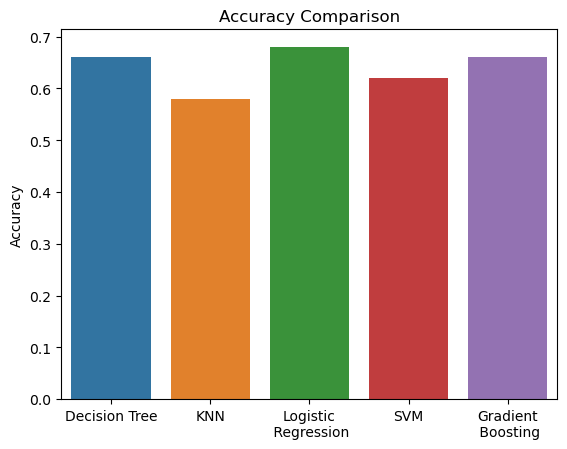

Classification Report for Decision Tree:
               precision    recall  f1-score  support
0              0.608696  0.636364  0.622222    22.00
1              0.703704  0.678571  0.690909    28.00
accuracy       0.660000  0.660000  0.660000     0.66
macro avg      0.656200  0.657468  0.656566    50.00
weighted avg   0.661900  0.660000  0.660687    50.00
Classification Report for KNN:
               precision    recall  f1-score  support
0              0.533333  0.363636  0.432432    22.00
1              0.600000  0.750000  0.666667    28.00
accuracy       0.580000  0.580000  0.580000     0.58
macro avg      0.566667  0.556818  0.549550    50.00
weighted avg   0.570667  0.580000  0.563604    50.00
Classification Report for Logistic
 Regression:
               precision    recall  f1-score  support
0              0.666667  0.545455  0.600000    22.00
1              0.687500  0.785714  0.733333    28.00
accuracy       0.680000  0.680000  0.680000     0.68
macro avg      0.677083  0.66

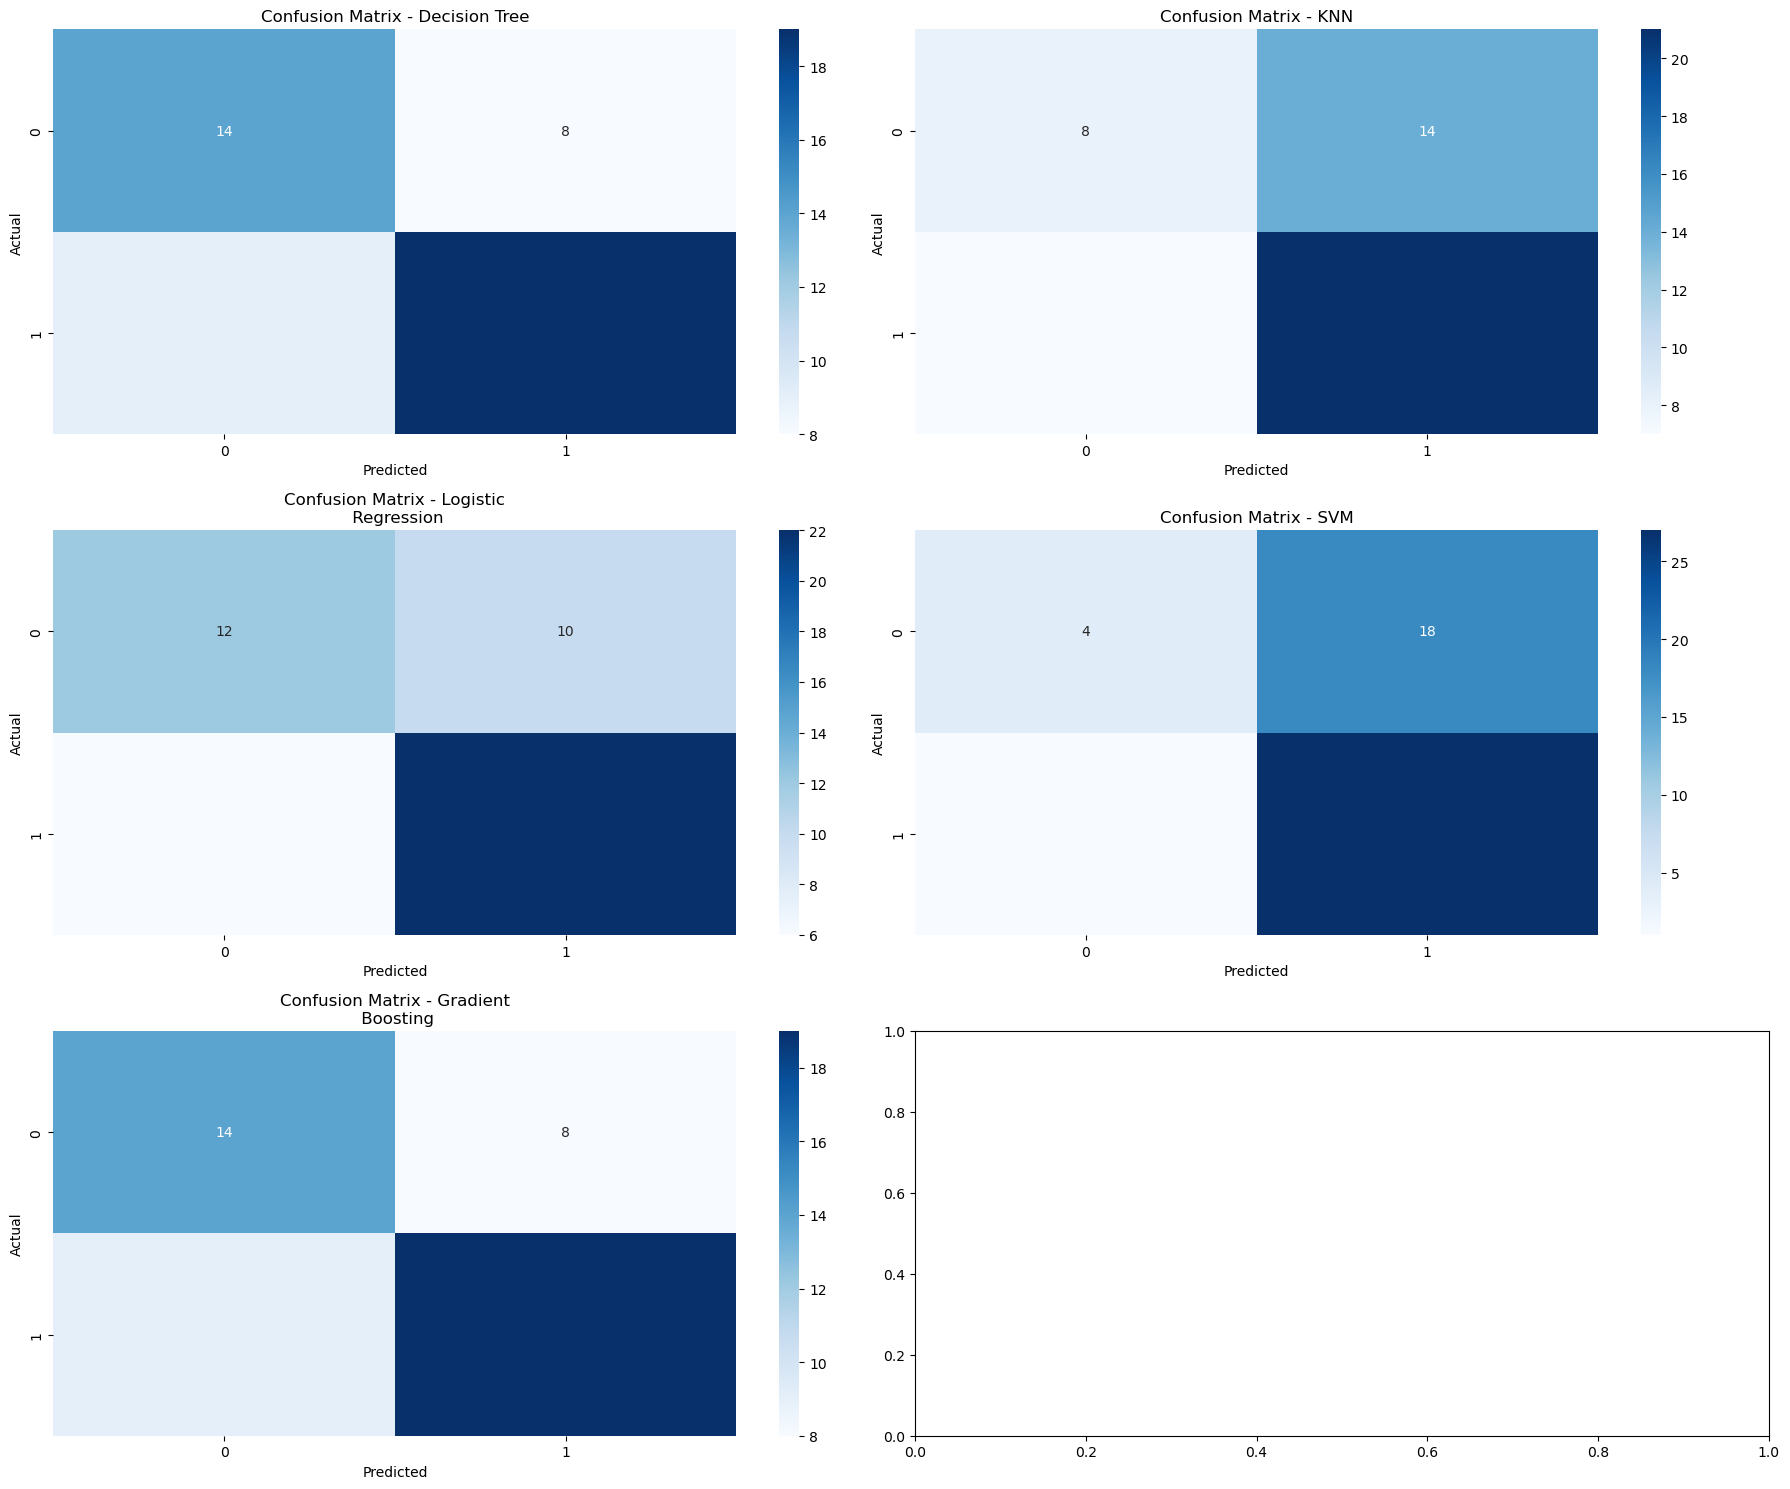

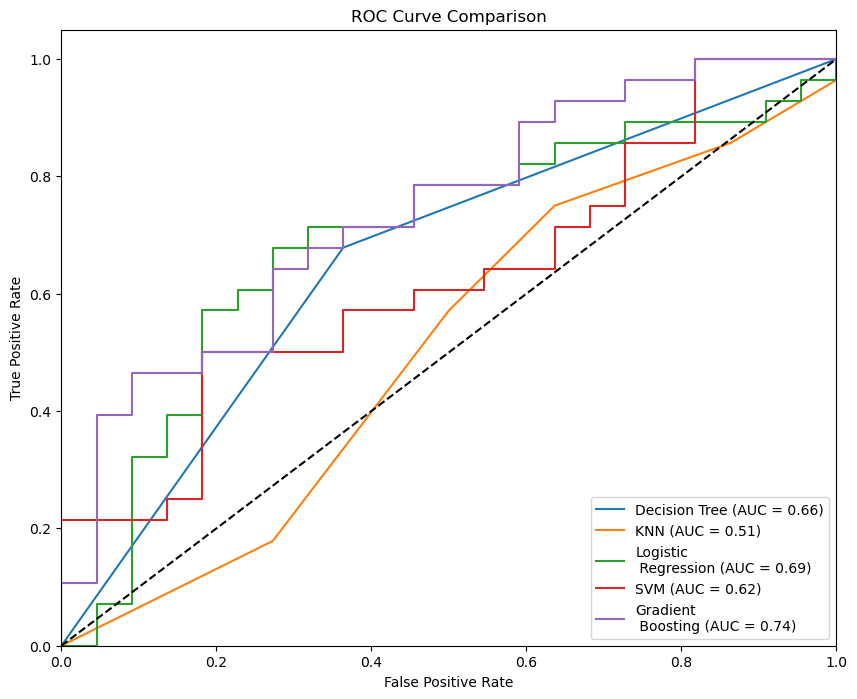

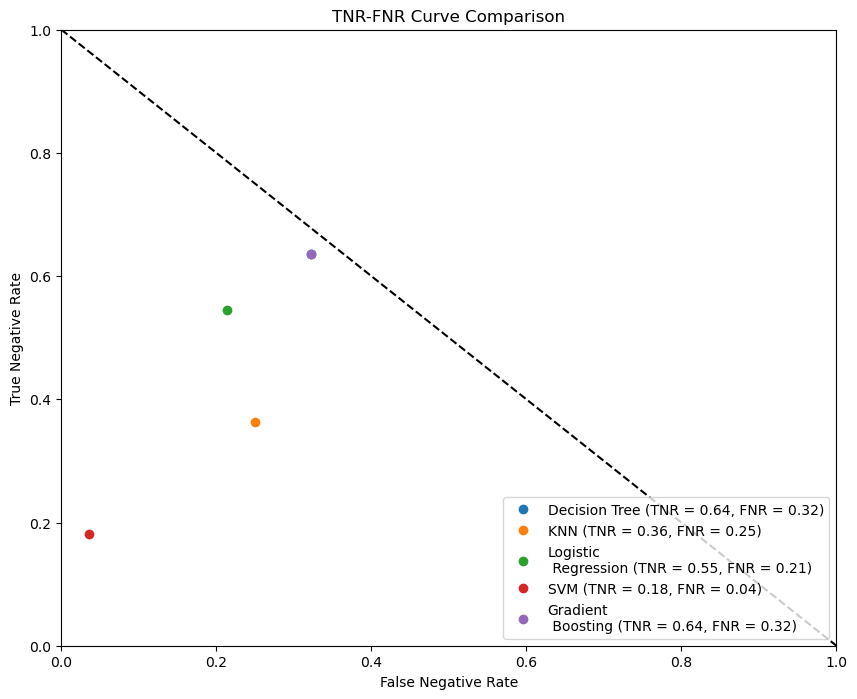

In [205]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc


X = df.drop(columns=['Class','Metastasis', 'HBcAb', 'Grams_day', 'Endemic', 'HBeAg'])
y = df['Class']

# Identificar colunas categóricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Aplicar One-Hot Encoding
X = pd.get_dummies(X, columns=categorical_cols)

# Dividir o dataset em conjunto de treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Garantir que os dados são contíguos em memória
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)

# Criar os modelos
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Logistic\n Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient\n Boosting': GradientBoostingClassifier(random_state=42),
}
# Treinar e avaliar os modelos
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob) if y_prob is not None else (None, None, None)
    roc_auc = auc(fpr, tpr) if y_prob is not None else None
    
    # Calculando TNR e FNR
    tn, fp, fn, tp = conf_matrix.ravel()
    tnr = tn / (tn + fp)  # True Negative Rate
    fnr = fn / (fn + tp)  # False Negative Rate
    
    # TNR-FNR curve
    tnr_fnr = (tnr, fnr)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'report': report,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'tnr_fnr': tnr_fnr,
    }

# Comparação de Acurácia
accuracy_data = {name: results[name]['accuracy'] for name in results.keys()}
accuracy_df = pd.DataFrame.from_dict(accuracy_data, orient='index', columns=['Accuracy'])
print(accuracy_df)

# Plotting accuracy
sns.barplot(x=accuracy_df.index, y='Accuracy', data=accuracy_df)
plt.title('Accuracy Comparison')
plt.show()

# Comparação do Relatório de Classificação
classification_reports = {name: pd.DataFrame(results[name]['report']).transpose() for name in results.keys()}

for name, report in classification_reports.items():
    print(f'Classification Report for {name}:\n', report)

# Matriz de Confusão
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

for ax, (name, result) in zip(axes.flatten(), results.items()):
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ROC Curve e AUC
plt.figure(figsize=(10, 8))

for name, result in results.items():
    if result['roc_auc'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

# TNR-FNR Curve
plt.figure(figsize=(10, 8))

for name, result in results.items():
    tnr, fnr = result['tnr_fnr']
    plt.plot(fnr, tnr, 'o', label=f'{name} (TNR = {tnr:.2f}, FNR = {fnr:.2f})')

plt.plot([0, 1], [1, 0], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Negative Rate')
plt.ylabel('True Negative Rate')
plt.title('TNR-FNR Curve Comparison')
plt.legend(loc='lower right')
plt.show()


**Sem as melhores 3 variáveis, de acordo com o sistema de pontos acima feito**

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc


X = df.drop(columns=['Class','Hemoglobin', 'Platelets', 'ALP'])
y = df['Class']

# Identificar colunas categóricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Aplicar One-Hot Encoding
X = pd.get_dummies(X, columns=categorical_cols)

# Dividir o dataset em conjunto de treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Garantir que os dados são contíguos em memória
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)

# Criar os modelos
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Logistic\n Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient\n Boosting': GradientBoostingClassifier(random_state=42),
}
# Treinar e avaliar os modelos
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob) if y_prob is not None else (None, None, None)
    roc_auc = auc(fpr, tpr) if y_prob is not None else None
    
    # Calculando TNR e FNR
    tn, fp, fn, tp = conf_matrix.ravel()
    tnr = tn / (tn + fp)  # True Negative Rate
    fnr = fn / (fn + tp)  # False Negative Rate
    
    # TNR-FNR curve
    tnr_fnr = (tnr, fnr)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'report': report,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'tnr_fnr': tnr_fnr,
    }

# Comparação de Acurácia
accuracy_data = {name: results[name]['accuracy'] for name in results.keys()}
accuracy_df = pd.DataFrame.from_dict(accuracy_data, orient='index', columns=['Accuracy'])
print(accuracy_df)

# Plotting accuracy
sns.barplot(x=accuracy_df.index, y='Accuracy', data=accuracy_df)
plt.title('Accuracy Comparison')
plt.show()

# Comparação do Relatório de Classificação
classification_reports = {name: pd.DataFrame(results[name]['report']).transpose() for name in results.keys()}

for name, report in classification_reports.items():
    print(f'Classification Report for {name}:\n', report)

# Matriz de Confusão
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

for ax, (name, result) in zip(axes.flatten(), results.items()):
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ROC Curve e AUC
plt.figure(figsize=(10, 8))

for name, result in results.items():
    if result['roc_auc'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

# TNR-FNR Curve
plt.figure(figsize=(10, 8))

for name, result in results.items():
    tnr, fnr = result['tnr_fnr']
    plt.plot(fnr, tnr, 'o', label=f'{name} (TNR = {tnr:.2f}, FNR = {fnr:.2f})')

plt.plot([0, 1], [1, 0], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Negative Rate')
plt.ylabel('True Negative Rate')
plt.title('TNR-FNR Curve Comparison')
plt.legend(loc='lower right')
plt.show()


**Sem as melhores 5 variáveis de acordo com a tabela**

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc


X = df.drop(columns=['Class','Hemoglobin', 'Platelets', 'ALP', 'Iron', 'Creatinine'])
y = df['Class']

# Identificar colunas categóricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Aplicar One-Hot Encoding
X = pd.get_dummies(X, columns=categorical_cols)

# Dividir o dataset em conjunto de treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Garantir que os dados são contíguos em memória
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)

# Criar os modelos
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Logistic\n Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient\n Boosting': GradientBoostingClassifier(random_state=42),
}
# Treinar e avaliar os modelos
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob) if y_prob is not None else (None, None, None)
    roc_auc = auc(fpr, tpr) if y_prob is not None else None
    
    # Calculando TNR e FNR
    tn, fp, fn, tp = conf_matrix.ravel()
    tnr = tn / (tn + fp)  # True Negative Rate
    fnr = fn / (fn + tp)  # False Negative Rate
    
    # TNR-FNR curve
    tnr_fnr = (tnr, fnr)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'report': report,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'tnr_fnr': tnr_fnr,
    }

# Comparação de Acurácia
accuracy_data = {name: results[name]['accuracy'] for name in results.keys()}
accuracy_df = pd.DataFrame.from_dict(accuracy_data, orient='index', columns=['Accuracy'])
print(accuracy_df)

# Plotting accuracy
sns.barplot(x=accuracy_df.index, y='Accuracy', data=accuracy_df)
plt.title('Accuracy Comparison')
plt.show()

# Comparação do Relatório de Classificação
classification_reports = {name: pd.DataFrame(results[name]['report']).transpose() for name in results.keys()}

for name, report in classification_reports.items():
    print(f'Classification Report for {name}:\n', report)

# Matriz de Confusão
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

for ax, (name, result) in zip(axes.flatten(), results.items()):
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ROC Curve e AUC
plt.figure(figsize=(10, 8))

for name, result in results.items():
    if result['roc_auc'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

# TNR-FNR Curve
plt.figure(figsize=(10, 8))

for name, result in results.items():
    tnr, fnr = result['tnr_fnr']
    plt.plot(fnr, tnr, 'o', label=f'{name} (TNR = {tnr:.2f}, FNR = {fnr:.2f})')

plt.plot([0, 1], [1, 0], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Negative Rate')
plt.ylabel('True Negative Rate')
plt.title('TNR-FNR Curve Comparison')
plt.legend(loc='lower right')
plt.show()


**Apenas com as melhores 3 variáveis, de acordo com a tabela**

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc


X = df[['Hemoglobin', 'Platelets', 'ALP']]
y = df['Class']

# Identificar colunas categóricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Aplicar One-Hot Encoding
X = pd.get_dummies(X, columns=categorical_cols)

# Dividir o dataset em conjunto de treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Garantir que os dados são contíguos em memória
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)

# Criar os modelos
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Logistic\n Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient\n Boosting': GradientBoostingClassifier(random_state=42),
}
# Treinar e avaliar os modelos
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob) if y_prob is not None else (None, None, None)
    roc_auc = auc(fpr, tpr) if y_prob is not None else None
    
    # Calculando TNR e FNR
    tn, fp, fn, tp = conf_matrix.ravel()
    tnr = tn / (tn + fp)  # True Negative Rate
    fnr = fn / (fn + tp)  # False Negative Rate
    
    # TNR-FNR curve
    tnr_fnr = (tnr, fnr)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'report': report,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'tnr_fnr': tnr_fnr,
    }

# Comparação de Acurácia
accuracy_data = {name: results[name]['accuracy'] for name in results.keys()}
accuracy_df = pd.DataFrame.from_dict(accuracy_data, orient='index', columns=['Accuracy'])
print(accuracy_df)

# Plotting accuracy
sns.barplot(x=accuracy_df.index, y='Accuracy', data=accuracy_df)
plt.title('Accuracy Comparison')
plt.show()

# Comparação do Relatório de Classificação
classification_reports = {name: pd.DataFrame(results[name]['report']).transpose() for name in results.keys()}

for name, report in classification_reports.items():
    print(f'Classification Report for {name}:\n', report)

# Matriz de Confusão
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

for ax, (name, result) in zip(axes.flatten(), results.items()):
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ROC Curve e AUC
plt.figure(figsize=(10, 8))

for name, result in results.items():
    if result['roc_auc'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

# TNR-FNR Curve
plt.figure(figsize=(10, 8))

for name, result in results.items():
    tnr, fnr = result['tnr_fnr']
    plt.plot(fnr, tnr, 'o', label=f'{name} (TNR = {tnr:.2f}, FNR = {fnr:.2f})')

plt.plot([0, 1], [1, 0], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Negative Rate')
plt.ylabel('True Negative Rate')
plt.title('TNR-FNR Curve Comparison')
plt.legend(loc='lower right')
plt.show()


**Apenas com as melhores 5 variáveis, de acordo com a tabela**

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

X = df[['Hemoglobin', 'Platelets', 'ALP', 'Iron', 'Creatinine']]
y = df['Class']

# Identificar colunas categóricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Aplicar One-Hot Encoding
X = pd.get_dummies(X, columns=categorical_cols)

# Dividir o dataset em conjunto de treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Garantir que os dados são contíguos em memória
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)

# Criar os modelos
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Logistic\n Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient\n Boosting': GradientBoostingClassifier(random_state=42),
}
# Treinar e avaliar os modelos
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob) if y_prob is not None else (None, None, None)
    roc_auc = auc(fpr, tpr) if y_prob is not None else None
    
    # Calculando TNR e FNR
    tn, fp, fn, tp = conf_matrix.ravel()
    tnr = tn / (tn + fp)  # True Negative Rate
    fnr = fn / (fn + tp)  # False Negative Rate
    
    # TNR-FNR curve
    tnr_fnr = (tnr, fnr)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'report': report,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'tnr_fnr': tnr_fnr,
    }

# Comparação de Acurácia
accuracy_data = {name: results[name]['accuracy'] for name in results.keys()}
accuracy_df = pd.DataFrame.from_dict(accuracy_data, orient='index', columns=['Accuracy'])
print(accuracy_df)

# Plotting accuracy
sns.barplot(x=accuracy_df.index, y='Accuracy', data=accuracy_df)
plt.title('Accuracy Comparison')
plt.show()

# Comparação do Relatório de Classificação
classification_reports = {name: pd.DataFrame(results[name]['report']).transpose() for name in results.keys()}

for name, report in classification_reports.items():
    print(f'Classification Report for {name}:\n', report)

# Matriz de Confusão
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

for ax, (name, result) in zip(axes.flatten(), results.items()):
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ROC Curve e AUC
plt.figure(figsize=(10, 8))

for name, result in results.items():
    if result['roc_auc'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

# TNR-FNR Curve
plt.figure(figsize=(10, 8))

for name, result in results.items():
    tnr, fnr = result['tnr_fnr']
    plt.plot(fnr, tnr, 'o', label=f'{name} (TNR = {tnr:.2f}, FNR = {fnr:.2f})')

plt.plot([0, 1], [1, 0], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Negative Rate')
plt.ylabel('True Negative Rate')
plt.title('TNR-FNR Curve Comparison')
plt.legend(loc='lower right')
plt.show()


**Apenas com as melhores 10 variáveis, de acordo com a tabela**

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

X = df[['Hemoglobin', 'Platelets', 'ALP', 'Iron', 'Creatinine', 'PVT', ' Albumin', 'Ascites', 'Symptoms', 'Diabetes']]
y = df['Class']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Aplicar One-Hot Encoding
X = pd.get_dummies(X, columns=categorical_cols)

# Dividir o dataset em conjunto de treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Garantir que os dados são contíguos em memória
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)

# Criar os modelos
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Logistic\n Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient\n Boosting': GradientBoostingClassifier(random_state=42),
}
# Treinar e avaliar os modelos
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob) if y_prob is not None else (None, None, None)
    roc_auc = auc(fpr, tpr) if y_prob is not None else None
    
    # Calculando TNR e FNR
    tn, fp, fn, tp = conf_matrix.ravel()
    tnr = tn / (tn + fp)  # True Negative Rate
    fnr = fn / (fn + tp)  # False Negative Rate
    
    # TNR-FNR curve
    tnr_fnr = (tnr, fnr)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'report': report,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'tnr_fnr': tnr_fnr,
    }

# Comparação de Acurácia
accuracy_data = {name: results[name]['accuracy'] for name in results.keys()}
accuracy_df = pd.DataFrame.from_dict(accuracy_data, orient='index', columns=['Accuracy'])
print(accuracy_df)

# Plotting accuracy
sns.barplot(x=accuracy_df.index, y='Accuracy', data=accuracy_df)
plt.title('Accuracy Comparison')
plt.show()

# Comparação do Relatório de Classificação
classification_reports = {name: pd.DataFrame(results[name]['report']).transpose() for name in results.keys()}

for name, report in classification_reports.items():
    print(f'Classification Report for {name}:\n', report)

# Matriz de Confusão
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

for ax, (name, result) in zip(axes.flatten(), results.items()):
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ROC Curve e AUC
plt.figure(figsize=(10, 8))

for name, result in results.items():
    if result['roc_auc'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

# TNR-FNR Curve
plt.figure(figsize=(10, 8))

for name, result in results.items():
    tnr, fnr = result['tnr_fnr']
    plt.plot(fnr, tnr, 'o', label=f'{name} (TNR = {tnr:.2f}, FNR = {fnr:.2f})')

plt.plot([0, 1], [1, 0], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Negative Rate')
plt.ylabel('True Negative Rate')
plt.title('TNR-FNR Curve Comparison')
plt.legend(loc='lower right')
plt.show()

**Apenas com as variáveis eliminadas a partir da leitura dos gráficos**

In [ ]:


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

X = df[['Symptoms', 'Diabetes', 'HBeAg', 'HIV', 'Endemic', 'Hemochro', 'HCVAb', 'NASH', 'Grams_day', 'INR', 'Total_Bil', 'TP']]
y = df['Class']

# Identificar colunas categóricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Aplicar One-Hot Encoding
X = pd.get_dummies(X, columns=categorical_cols)

# Dividir o dataset em conjunto de treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Garantir que os dados são contíguos em memória
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)

# Criar os modelos
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Logistic\n Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient\n Boosting': GradientBoostingClassifier(random_state=42),
}
# Treinar e avaliar os modelos
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob) if y_prob is not None else (None, None, None)
    roc_auc = auc(fpr, tpr) if y_prob is not None else None
    
    # Calculando TNR e FNR
    tn, fp, fn, tp = conf_matrix.ravel()
    tnr = tn / (tn + fp)  # True Negative Rate
    fnr = fn / (fn + tp)  # False Negative Rate
    
    # TNR-FNR curve
    tnr_fnr = (tnr, fnr)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'report': report,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'tnr_fnr': tnr_fnr,
    }

# Comparação de Acurácia
accuracy_data = {name: results[name]['accuracy'] for name in results.keys()}
accuracy_df = pd.DataFrame.from_dict(accuracy_data, orient='index', columns=['Accuracy'])
print(accuracy_df)

# Plotting accuracy
sns.barplot(x=accuracy_df.index, y='Accuracy', data=accuracy_df)
plt.title('Accuracy Comparison')
plt.show()

# Comparação do Relatório de Classificação
classification_reports = {name: pd.DataFrame(results[name]['report']).transpose() for name in results.keys()}

for name, report in classification_reports.items():
    print(f'Classification Report for {name}:\n', report)

# Matriz de Confusão
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

for ax, (name, result) in zip(axes.flatten(), results.items()):
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ROC Curve e AUC
plt.figure(figsize=(10, 8))

for name, result in results.items():
    if result['roc_auc'] is not None:
        plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

# TNR-FNR Curve
plt.figure(figsize=(10, 8))

for name, result in results.items():
    tnr, fnr = result['tnr_fnr']
    plt.plot(fnr, tnr, 'o', label=f'{name} (TNR = {tnr:.2f}, FNR = {fnr:.2f})')

plt.plot([0, 1], [1, 0], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Negative Rate')
plt.ylabel('True Negative Rate')
plt.title('TNR-FNR Curve Comparison')
plt.legend(loc='lower right')
plt.show()
